In [1]:

import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        hist = {"iter": [], "loss": []}
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                hist["iter"].append(it)
                hist["loss"].append(loss_value)
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback) 
        return hist
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star

/home/chuan/venv/python3.7-tensorflow1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chuan/venv/python3.7-tensorflow1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chuan/venv/python3.7-tensorflow1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chuan/venv/python3.

In [2]:
noise = 0.0        

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

start_time = time.time()                
hist = model.train(50000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
It: 0, Loss: 7.274e-01, Time: 1.31
It: 10, Loss: 5.386e-01, Time: 3.02
It: 20, Loss: 4.618e-01, Time: 3.02
It: 30, Loss: 4.528e-01, Time: 3.03
It: 40, Loss: 4.411e-01, Time: 3.03
It: 50, Loss: 4.317e-01, Time: 3.03
It: 60, Loss: 4.104e-01, Time: 3.04
It: 70, Loss: 3.751e-01, Time: 3.03
It: 80, Loss: 3.260e-01, Time: 3.01
It: 90, Loss: 2.706e-01, Time: 3.02
It: 100, Loss: 2.063e-01, Time: 3.02
It: 110, Loss: 1.701e-01, Time: 3.03
It: 120, Loss: 1.555e-01, Time: 3.03
It: 130, Loss: 1.469e-01, Time: 3.00
It: 140, Loss: 1.372e-01, Time: 3.0

It: 1990, Loss: 1.715e-02, Time: 2.97
It: 2000, Loss: 1.714e-02, Time: 2.99
It: 2010, Loss: 1.702e-02, Time: 3.00
It: 2020, Loss: 1.675e-02, Time: 3.00
It: 2030, Loss: 1.665e-02, Time: 3.00
It: 2040, Loss: 1.669e-02, Time: 3.00
It: 2050, Loss: 2.994e-02, Time: 2.99
It: 2060, Loss: 2.633e-02, Time: 3.01
It: 2070, Loss: 1.692e-02, Time: 2.98
It: 2080, Loss: 1.665e-02, Time: 3.00
It: 2090, Loss: 1.632e-02, Time: 2.99
It: 2100, Loss: 1.599e-02, Time: 2.99
It: 2110, Loss: 1.580e-02, Time: 3.00
It: 2120, Loss: 1.569e-02, Time: 2.98
It: 2130, Loss: 1.599e-02, Time: 2.99
It: 2140, Loss: 4.042e-02, Time: 3.01
It: 2150, Loss: 1.638e-02, Time: 2.99
It: 2160, Loss: 1.552e-02, Time: 2.99
It: 2170, Loss: 1.546e-02, Time: 3.00
It: 2180, Loss: 1.539e-02, Time: 3.00
It: 2190, Loss: 1.514e-02, Time: 3.00
It: 2200, Loss: 1.509e-02, Time: 2.99
It: 2210, Loss: 2.501e-02, Time: 2.99
It: 2220, Loss: 2.392e-02, Time: 2.98
It: 2230, Loss: 1.502e-02, Time: 3.00
It: 2240, Loss: 1.595e-02, Time: 3.01
It: 2250, Lo

It: 4150, Loss: 5.802e-03, Time: 3.00
It: 4160, Loss: 5.778e-03, Time: 3.00
It: 4170, Loss: 6.238e-03, Time: 3.00
It: 4180, Loss: 4.264e-02, Time: 3.00
It: 4190, Loss: 9.012e-03, Time: 3.00
It: 4200, Loss: 9.661e-03, Time: 2.97
It: 4210, Loss: 6.957e-03, Time: 3.00
It: 4220, Loss: 5.965e-03, Time: 3.01
It: 4230, Loss: 5.755e-03, Time: 2.99
It: 4240, Loss: 5.628e-03, Time: 3.01
It: 4250, Loss: 5.609e-03, Time: 3.00
It: 4260, Loss: 5.551e-03, Time: 2.98
It: 4270, Loss: 5.518e-03, Time: 3.00
It: 4280, Loss: 5.486e-03, Time: 3.00
It: 4290, Loss: 5.454e-03, Time: 3.00
It: 4300, Loss: 5.422e-03, Time: 3.00
It: 4310, Loss: 5.391e-03, Time: 2.99
It: 4320, Loss: 5.362e-03, Time: 2.99
It: 4330, Loss: 5.505e-03, Time: 3.02
It: 4340, Loss: 3.037e-02, Time: 3.01
It: 4350, Loss: 2.067e-02, Time: 3.00
It: 4360, Loss: 1.106e-02, Time: 3.01
It: 4370, Loss: 7.329e-03, Time: 2.99
It: 4380, Loss: 6.028e-03, Time: 2.99
It: 4390, Loss: 5.513e-03, Time: 2.99
It: 4400, Loss: 5.281e-03, Time: 2.97
It: 4410, Lo

It: 6310, Loss: 2.278e-03, Time: 2.99
It: 6320, Loss: 2.265e-03, Time: 2.99
It: 6330, Loss: 2.253e-03, Time: 2.99
It: 6340, Loss: 2.396e-03, Time: 2.98
It: 6350, Loss: 2.650e-02, Time: 3.00
It: 6360, Loss: 2.147e-02, Time: 2.99
It: 6370, Loss: 9.155e-03, Time: 2.99
It: 6380, Loss: 4.753e-03, Time: 2.98
It: 6390, Loss: 3.062e-03, Time: 2.98
It: 6400, Loss: 2.482e-03, Time: 3.02
It: 6410, Loss: 2.260e-03, Time: 3.01
It: 6420, Loss: 2.215e-03, Time: 2.97
It: 6430, Loss: 2.207e-03, Time: 2.99
It: 6440, Loss: 2.184e-03, Time: 2.99
It: 6450, Loss: 2.170e-03, Time: 3.01
It: 6460, Loss: 2.156e-03, Time: 2.99
It: 6470, Loss: 2.143e-03, Time: 3.00
It: 6480, Loss: 2.130e-03, Time: 3.00
It: 6490, Loss: 2.117e-03, Time: 3.00
It: 6500, Loss: 2.105e-03, Time: 2.98
It: 6510, Loss: 2.094e-03, Time: 2.99
It: 6520, Loss: 2.152e-03, Time: 3.01
It: 6530, Loss: 1.183e-02, Time: 2.99
It: 6540, Loss: 1.103e-02, Time: 2.99
It: 6550, Loss: 5.453e-03, Time: 2.99
It: 6560, Loss: 3.133e-03, Time: 2.99
It: 6570, Lo

It: 8470, Loss: 1.726e-03, Time: 3.00
It: 8480, Loss: 1.689e-03, Time: 2.98
It: 8490, Loss: 1.367e-03, Time: 2.99
It: 8500, Loss: 1.192e-03, Time: 2.99
It: 8510, Loss: 1.140e-03, Time: 2.99
It: 8520, Loss: 1.113e-03, Time: 3.02
It: 8530, Loss: 1.093e-03, Time: 2.99
It: 8540, Loss: 1.090e-03, Time: 3.01
It: 8550, Loss: 1.094e-03, Time: 3.00
It: 8560, Loss: 1.319e-03, Time: 3.00
It: 8570, Loss: 1.145e-02, Time: 2.99
It: 8580, Loss: 5.617e-03, Time: 2.99
It: 8590, Loss: 3.714e-03, Time: 2.98
It: 8600, Loss: 1.599e-03, Time: 2.99
It: 8610, Loss: 1.544e-03, Time: 2.99
It: 8620, Loss: 1.128e-03, Time: 2.99
It: 8630, Loss: 1.079e-03, Time: 2.99
It: 8640, Loss: 1.072e-03, Time: 2.98
It: 8650, Loss: 1.102e-03, Time: 3.01
It: 8660, Loss: 5.988e-03, Time: 2.99
It: 8670, Loss: 2.690e-03, Time: 3.00
It: 8680, Loss: 3.283e-03, Time: 2.99
It: 8690, Loss: 2.096e-03, Time: 3.01
It: 8700, Loss: 1.555e-03, Time: 2.99
It: 8710, Loss: 1.317e-03, Time: 3.02
It: 8720, Loss: 1.150e-03, Time: 3.00
It: 8730, Lo

It: 10610, Loss: 6.888e-04, Time: 2.98
It: 10620, Loss: 6.685e-04, Time: 2.99
It: 10630, Loss: 6.610e-04, Time: 2.99
It: 10640, Loss: 6.625e-04, Time: 2.99
It: 10650, Loss: 8.576e-04, Time: 3.00
It: 10660, Loss: 2.496e-02, Time: 3.00
It: 10670, Loss: 9.302e-03, Time: 3.00
It: 10680, Loss: 3.660e-03, Time: 2.99
It: 10690, Loss: 1.495e-03, Time: 2.97
It: 10700, Loss: 9.496e-04, Time: 3.00
It: 10710, Loss: 7.933e-04, Time: 2.99
It: 10720, Loss: 7.038e-04, Time: 3.00
It: 10730, Loss: 6.679e-04, Time: 3.00
It: 10740, Loss: 6.619e-04, Time: 2.98
It: 10750, Loss: 6.576e-04, Time: 2.99
It: 10760, Loss: 6.519e-04, Time: 2.99
It: 10770, Loss: 6.519e-04, Time: 2.99
It: 10780, Loss: 9.730e-04, Time: 3.00
It: 10790, Loss: 2.924e-02, Time: 3.01
It: 10800, Loss: 6.861e-03, Time: 2.99
It: 10810, Loss: 3.094e-03, Time: 3.01
It: 10820, Loss: 1.399e-03, Time: 2.97
It: 10830, Loss: 7.811e-04, Time: 3.00
It: 10840, Loss: 8.263e-04, Time: 3.01
It: 10850, Loss: 6.749e-04, Time: 2.99
It: 10860, Loss: 6.562e-0

It: 12720, Loss: 1.588e-02, Time: 2.99
It: 12730, Loss: 3.544e-03, Time: 3.01
It: 12740, Loss: 1.199e-03, Time: 2.98
It: 12750, Loss: 9.139e-04, Time: 2.99
It: 12760, Loss: 7.196e-04, Time: 3.00
It: 12770, Loss: 5.414e-04, Time: 2.98
It: 12780, Loss: 5.018e-04, Time: 2.97
It: 12790, Loss: 4.979e-04, Time: 3.00
It: 12800, Loss: 7.208e-04, Time: 2.97
It: 12810, Loss: 1.149e-02, Time: 2.98
It: 12820, Loss: 5.059e-03, Time: 2.98
It: 12830, Loss: 2.857e-03, Time: 2.98
It: 12840, Loss: 7.565e-04, Time: 2.99
It: 12850, Loss: 8.593e-04, Time: 3.01
It: 12860, Loss: 5.345e-04, Time: 2.98
It: 12870, Loss: 4.791e-04, Time: 2.99
It: 12880, Loss: 4.831e-04, Time: 2.97
It: 12890, Loss: 4.854e-04, Time: 2.98
It: 12900, Loss: 8.826e-04, Time: 2.99
It: 12910, Loss: 1.041e-02, Time: 3.00
It: 12920, Loss: 1.794e-03, Time: 3.00
It: 12930, Loss: 1.243e-03, Time: 2.98
It: 12940, Loss: 7.583e-04, Time: 3.02
It: 12950, Loss: 5.942e-04, Time: 2.99
It: 12960, Loss: 5.122e-04, Time: 2.98
It: 12970, Loss: 4.928e-0

It: 14830, Loss: 5.972e-04, Time: 2.99
It: 14840, Loss: 1.294e-03, Time: 2.99
It: 14850, Loss: 1.053e-02, Time: 2.99
It: 14860, Loss: 3.360e-03, Time: 2.99
It: 14870, Loss: 1.665e-03, Time: 2.99
It: 14880, Loss: 7.988e-04, Time: 2.98
It: 14890, Loss: 5.307e-04, Time: 3.00
It: 14900, Loss: 4.426e-04, Time: 3.00
It: 14910, Loss: 4.246e-04, Time: 3.00
It: 14920, Loss: 3.221e-03, Time: 2.99
It: 14930, Loss: 5.104e-03, Time: 2.98
It: 14940, Loss: 3.380e-03, Time: 2.99
It: 14950, Loss: 1.796e-03, Time: 3.00
It: 14960, Loss: 4.221e-04, Time: 3.00
It: 14970, Loss: 5.014e-04, Time: 2.99
It: 14980, Loss: 4.649e-04, Time: 2.99
It: 14990, Loss: 3.854e-04, Time: 3.00
It: 15000, Loss: 3.821e-04, Time: 2.99
It: 15010, Loss: 3.736e-04, Time: 3.00
It: 15020, Loss: 3.816e-04, Time: 3.00
It: 15030, Loss: 9.663e-04, Time: 2.99
It: 15040, Loss: 4.006e-03, Time: 3.00
It: 15050, Loss: 1.378e-02, Time: 2.98
It: 15060, Loss: 4.392e-03, Time: 2.99
It: 15070, Loss: 9.511e-04, Time: 2.97
It: 15080, Loss: 3.979e-0

It: 16940, Loss: 3.292e-04, Time: 2.99
It: 16950, Loss: 6.352e-04, Time: 3.00
It: 16960, Loss: 1.680e-02, Time: 3.00
It: 16970, Loss: 6.730e-03, Time: 2.98
It: 16980, Loss: 1.407e-03, Time: 2.98
It: 16990, Loss: 5.708e-04, Time: 3.01
It: 17000, Loss: 6.234e-04, Time: 2.99
It: 17010, Loss: 3.380e-04, Time: 3.00
It: 17020, Loss: 3.554e-04, Time: 2.97
It: 17030, Loss: 3.253e-04, Time: 2.98
It: 17040, Loss: 3.170e-04, Time: 2.99
It: 17050, Loss: 3.171e-04, Time: 2.99
It: 17060, Loss: 3.684e-04, Time: 2.99
It: 17070, Loss: 3.061e-03, Time: 2.99
It: 17080, Loss: 1.991e-03, Time: 2.99
It: 17090, Loss: 2.230e-03, Time: 2.99
It: 17100, Loss: 7.564e-04, Time: 3.00
It: 17110, Loss: 5.754e-04, Time: 3.00
It: 17120, Loss: 3.642e-04, Time: 2.97
It: 17130, Loss: 3.513e-04, Time: 2.99
It: 17140, Loss: 3.285e-04, Time: 2.98
It: 17150, Loss: 3.172e-04, Time: 3.00
It: 17160, Loss: 4.355e-04, Time: 3.00
It: 17170, Loss: 5.275e-03, Time: 2.99
It: 17180, Loss: 6.555e-03, Time: 2.99
It: 17190, Loss: 2.044e-0

It: 19050, Loss: 2.954e-04, Time: 2.98
It: 19060, Loss: 2.862e-04, Time: 2.99
It: 19070, Loss: 3.224e-04, Time: 2.99
It: 19080, Loss: 1.137e-03, Time: 2.98
It: 19090, Loss: 6.503e-03, Time: 3.00
It: 19100, Loss: 1.295e-03, Time: 2.99
It: 19110, Loss: 5.061e-04, Time: 3.00
It: 19120, Loss: 4.793e-04, Time: 3.00
It: 19130, Loss: 3.863e-04, Time: 2.98
It: 19140, Loss: 5.570e-04, Time: 2.98
It: 19150, Loss: 4.947e-03, Time: 2.99
It: 19160, Loss: 9.829e-04, Time: 3.00
It: 19170, Loss: 9.339e-04, Time: 2.99
It: 19180, Loss: 7.989e-04, Time: 2.98
It: 19190, Loss: 4.546e-04, Time: 3.00
It: 19200, Loss: 3.385e-04, Time: 2.99
It: 19210, Loss: 3.743e-04, Time: 3.00
It: 19220, Loss: 1.965e-03, Time: 3.00
It: 19230, Loss: 1.041e-02, Time: 2.98
It: 19240, Loss: 2.855e-03, Time: 3.00
It: 19250, Loss: 9.803e-04, Time: 2.97
It: 19260, Loss: 8.022e-04, Time: 2.97
It: 19270, Loss: 4.839e-04, Time: 3.01
It: 19280, Loss: 3.080e-04, Time: 2.97
It: 19290, Loss: 2.993e-04, Time: 2.98
It: 19300, Loss: 2.707e-0

It: 21160, Loss: 2.642e-04, Time: 2.99
It: 21170, Loss: 2.807e-04, Time: 2.98
It: 21180, Loss: 2.367e-04, Time: 3.00
It: 21190, Loss: 2.430e-04, Time: 2.99
It: 21200, Loss: 3.720e-04, Time: 2.99
It: 21210, Loss: 8.916e-03, Time: 3.00
It: 21220, Loss: 6.240e-03, Time: 2.99
It: 21230, Loss: 9.365e-04, Time: 2.97
It: 21240, Loss: 4.654e-04, Time: 3.00
It: 21250, Loss: 4.555e-04, Time: 2.97
It: 21260, Loss: 3.068e-04, Time: 3.00
It: 21270, Loss: 2.465e-04, Time: 2.97
It: 21280, Loss: 2.733e-04, Time: 2.98
It: 21290, Loss: 2.138e-03, Time: 2.98
It: 21300, Loss: 4.772e-03, Time: 2.98
It: 21310, Loss: 2.298e-03, Time: 2.99
It: 21320, Loss: 6.188e-04, Time: 2.99
It: 21330, Loss: 6.361e-04, Time: 2.96
It: 21340, Loss: 2.881e-04, Time: 2.99
It: 21350, Loss: 2.739e-04, Time: 3.00
It: 21360, Loss: 2.592e-04, Time: 2.97
It: 21370, Loss: 3.895e-04, Time: 2.99
It: 21380, Loss: 6.764e-03, Time: 2.98
It: 21390, Loss: 2.460e-03, Time: 2.99
It: 21400, Loss: 1.219e-03, Time: 2.99
It: 21410, Loss: 7.491e-0

It: 23270, Loss: 2.960e-04, Time: 2.99
It: 23280, Loss: 2.159e-03, Time: 2.99
It: 23290, Loss: 2.294e-03, Time: 2.98
It: 23300, Loss: 2.214e-03, Time: 2.99
It: 23310, Loss: 9.472e-04, Time: 2.98
It: 23320, Loss: 5.109e-04, Time: 2.98
It: 23330, Loss: 6.753e-04, Time: 2.99
It: 23340, Loss: 1.473e-03, Time: 2.98
It: 23350, Loss: 1.985e-03, Time: 2.99
It: 23360, Loss: 2.504e-04, Time: 3.01
It: 23370, Loss: 8.518e-04, Time: 2.98
It: 23380, Loss: 2.115e-03, Time: 3.00
It: 23390, Loss: 6.644e-03, Time: 2.99
It: 23400, Loss: 1.998e-03, Time: 3.00
It: 23410, Loss: 8.493e-04, Time: 3.00
It: 23420, Loss: 4.016e-04, Time: 2.98
It: 23430, Loss: 2.636e-04, Time: 2.99
It: 23440, Loss: 2.359e-04, Time: 2.99
It: 23450, Loss: 3.150e-04, Time: 3.00
It: 23460, Loss: 2.307e-03, Time: 2.98
It: 23470, Loss: 1.927e-03, Time: 2.98
It: 23480, Loss: 7.779e-03, Time: 3.01
It: 23490, Loss: 1.851e-03, Time: 2.98
It: 23500, Loss: 1.030e-03, Time: 2.99
It: 23510, Loss: 4.150e-04, Time: 3.00
It: 23520, Loss: 3.145e-0

It: 25380, Loss: 2.120e-04, Time: 2.98
It: 25390, Loss: 2.012e-04, Time: 2.99
It: 25400, Loss: 2.103e-04, Time: 2.98
It: 25410, Loss: 3.234e-04, Time: 2.99
It: 25420, Loss: 5.440e-03, Time: 2.98
It: 25430, Loss: 9.450e-04, Time: 2.99
It: 25440, Loss: 1.866e-03, Time: 2.98
It: 25450, Loss: 3.452e-04, Time: 3.00
It: 25460, Loss: 3.925e-04, Time: 2.99
It: 25470, Loss: 2.500e-04, Time: 3.01
It: 25480, Loss: 1.831e-04, Time: 2.99
It: 25490, Loss: 1.844e-04, Time: 2.99
It: 25500, Loss: 5.699e-04, Time: 2.97
It: 25510, Loss: 3.288e-03, Time: 2.99
It: 25520, Loss: 6.935e-03, Time: 2.99
It: 25530, Loss: 1.048e-03, Time: 2.98
It: 25540, Loss: 7.268e-04, Time: 3.00
It: 25550, Loss: 5.351e-04, Time: 3.00
It: 25560, Loss: 2.898e-04, Time: 2.99
It: 25570, Loss: 2.171e-04, Time: 2.99
It: 25580, Loss: 1.874e-04, Time: 2.98
It: 25590, Loss: 1.825e-04, Time: 2.99
It: 25600, Loss: 3.015e-04, Time: 2.99
It: 25610, Loss: 4.782e-03, Time: 3.00
It: 25620, Loss: 1.766e-03, Time: 3.00
It: 25630, Loss: 1.594e-0

It: 27490, Loss: 7.403e-04, Time: 3.00
It: 27500, Loss: 5.696e-04, Time: 2.99
It: 27510, Loss: 4.342e-04, Time: 3.00
It: 27520, Loss: 4.316e-04, Time: 3.00
It: 27530, Loss: 2.541e-03, Time: 2.98
It: 27540, Loss: 7.562e-04, Time: 2.98
It: 27550, Loss: 6.840e-04, Time: 2.99
It: 27560, Loss: 4.705e-04, Time: 2.99
It: 27570, Loss: 2.887e-04, Time: 3.00
It: 27580, Loss: 4.666e-04, Time: 3.01
It: 27590, Loss: 9.823e-03, Time: 2.98
It: 27600, Loss: 3.855e-03, Time: 2.99
It: 27610, Loss: 9.579e-04, Time: 2.98
It: 27620, Loss: 4.134e-04, Time: 2.98
It: 27630, Loss: 3.480e-04, Time: 3.00
It: 27640, Loss: 1.827e-04, Time: 2.97
It: 27650, Loss: 2.989e-04, Time: 3.00
It: 27660, Loss: 4.593e-03, Time: 2.99
It: 27670, Loss: 6.914e-04, Time: 3.01
It: 27680, Loss: 1.435e-03, Time: 2.99
It: 27690, Loss: 6.001e-04, Time: 3.00
It: 27700, Loss: 2.253e-04, Time: 2.99
It: 27710, Loss: 1.816e-04, Time: 2.99
It: 27720, Loss: 1.741e-04, Time: 2.98
It: 27730, Loss: 2.004e-04, Time: 2.98
It: 27740, Loss: 1.696e-0

It: 29600, Loss: 1.745e-03, Time: 3.00
It: 29610, Loss: 1.188e-03, Time: 2.99
It: 29620, Loss: 8.114e-04, Time: 2.97
It: 29630, Loss: 2.747e-04, Time: 2.98
It: 29640, Loss: 1.949e-04, Time: 2.99
It: 29650, Loss: 1.851e-04, Time: 3.00
It: 29660, Loss: 1.031e-03, Time: 3.02
It: 29670, Loss: 7.327e-04, Time: 2.99
It: 29680, Loss: 8.672e-04, Time: 2.98
It: 29690, Loss: 3.941e-03, Time: 2.99
It: 29700, Loss: 8.447e-04, Time: 2.99
It: 29710, Loss: 3.181e-04, Time: 3.00
It: 29720, Loss: 2.809e-04, Time: 2.99
It: 29730, Loss: 2.055e-04, Time: 2.99
It: 29740, Loss: 1.665e-04, Time: 2.99
It: 29750, Loss: 1.745e-04, Time: 2.97
It: 29760, Loss: 4.744e-04, Time: 3.01
It: 29770, Loss: 7.837e-03, Time: 2.99
It: 29780, Loss: 3.024e-03, Time: 3.00
It: 29790, Loss: 8.737e-04, Time: 3.00
It: 29800, Loss: 2.416e-04, Time: 2.99
It: 29810, Loss: 2.096e-04, Time: 2.98
It: 29820, Loss: 1.963e-04, Time: 3.01
It: 29830, Loss: 8.470e-04, Time: 2.97
It: 29840, Loss: 1.240e-02, Time: 2.99
It: 29850, Loss: 2.126e-0

It: 31710, Loss: 2.006e-03, Time: 2.98
It: 31720, Loss: 1.550e-03, Time: 2.98
It: 31730, Loss: 2.225e-04, Time: 3.00
It: 31740, Loss: 3.411e-04, Time: 2.99
It: 31750, Loss: 1.562e-04, Time: 2.98
It: 31760, Loss: 1.618e-04, Time: 2.98
It: 31770, Loss: 1.399e-04, Time: 2.99
It: 31780, Loss: 1.527e-04, Time: 2.99
It: 31790, Loss: 1.113e-03, Time: 3.01
It: 31800, Loss: 8.465e-03, Time: 3.01
It: 31810, Loss: 1.148e-03, Time: 2.99
It: 31820, Loss: 1.251e-03, Time: 3.00
It: 31830, Loss: 3.126e-04, Time: 2.99
It: 31840, Loss: 2.763e-04, Time: 2.99
It: 31850, Loss: 1.511e-04, Time: 3.00
It: 31860, Loss: 1.533e-04, Time: 3.00
It: 31870, Loss: 1.465e-04, Time: 2.98
It: 31880, Loss: 2.447e-04, Time: 2.99
It: 31890, Loss: 5.301e-03, Time: 2.98
It: 31900, Loss: 4.238e-03, Time: 2.99
It: 31910, Loss: 9.279e-04, Time: 2.99
It: 31920, Loss: 7.948e-04, Time: 2.99
It: 31930, Loss: 2.655e-04, Time: 3.01
It: 31940, Loss: 2.163e-04, Time: 2.98
It: 31950, Loss: 1.486e-04, Time: 2.97
It: 31960, Loss: 1.432e-0

It: 33820, Loss: 1.718e-03, Time: 2.99
It: 33830, Loss: 2.727e-03, Time: 2.97
It: 33840, Loss: 8.430e-04, Time: 2.99
It: 33850, Loss: 2.459e-04, Time: 2.99
It: 33860, Loss: 3.316e-04, Time: 2.99
It: 33870, Loss: 3.919e-04, Time: 3.01
It: 33880, Loss: 1.891e-03, Time: 2.99
It: 33890, Loss: 2.148e-03, Time: 2.99
It: 33900, Loss: 1.541e-03, Time: 2.98
It: 33910, Loss: 6.865e-04, Time: 2.98
It: 33920, Loss: 5.770e-04, Time: 3.00
It: 33930, Loss: 2.847e-03, Time: 3.00
It: 33940, Loss: 1.957e-03, Time: 2.99
It: 33950, Loss: 1.786e-03, Time: 2.99
It: 33960, Loss: 6.054e-04, Time: 3.01
It: 33970, Loss: 2.631e-04, Time: 2.98
It: 33980, Loss: 2.744e-04, Time: 3.00
It: 33990, Loss: 4.016e-04, Time: 2.98
It: 34000, Loss: 2.659e-03, Time: 2.99
It: 34010, Loss: 1.580e-03, Time: 2.98
It: 34020, Loss: 8.449e-04, Time: 2.98
It: 34030, Loss: 5.046e-04, Time: 2.98
It: 34040, Loss: 3.419e-04, Time: 2.99
It: 34050, Loss: 3.965e-04, Time: 2.99
It: 34060, Loss: 2.509e-03, Time: 2.98
It: 34070, Loss: 4.172e-0

It: 35930, Loss: 8.890e-04, Time: 3.00
It: 35940, Loss: 1.135e-03, Time: 2.99
It: 35950, Loss: 4.183e-04, Time: 2.97
It: 35960, Loss: 2.323e-04, Time: 2.99
It: 35970, Loss: 1.573e-04, Time: 2.99
It: 35980, Loss: 1.288e-04, Time: 3.00
It: 35990, Loss: 1.579e-04, Time: 3.00
It: 36000, Loss: 1.226e-03, Time: 2.99
It: 36010, Loss: 6.020e-03, Time: 3.00
It: 36020, Loss: 3.432e-04, Time: 2.99
It: 36030, Loss: 6.716e-04, Time: 2.99
It: 36040, Loss: 4.334e-04, Time: 2.98
It: 36050, Loss: 2.422e-04, Time: 3.01
It: 36060, Loss: 1.726e-04, Time: 3.02
It: 36070, Loss: 3.175e-04, Time: 2.99
It: 36080, Loss: 5.410e-03, Time: 2.99
It: 36090, Loss: 2.855e-03, Time: 2.98
It: 36100, Loss: 4.847e-04, Time: 2.98
It: 36110, Loss: 4.267e-04, Time: 3.00
It: 36120, Loss: 2.355e-04, Time: 2.99
It: 36130, Loss: 1.510e-04, Time: 2.98
It: 36140, Loss: 1.555e-04, Time: 2.98
It: 36150, Loss: 3.064e-04, Time: 3.00
It: 36160, Loss: 3.416e-03, Time: 2.98
It: 36170, Loss: 1.312e-03, Time: 2.98
It: 36180, Loss: 6.523e-0

It: 38040, Loss: 3.833e-04, Time: 2.99
It: 38050, Loss: 3.647e-03, Time: 2.98
It: 38060, Loss: 1.799e-03, Time: 2.98
It: 38070, Loss: 1.267e-03, Time: 2.99
It: 38080, Loss: 6.778e-04, Time: 3.00
It: 38090, Loss: 8.899e-04, Time: 2.99
It: 38100, Loss: 1.008e-03, Time: 3.01
It: 38110, Loss: 4.130e-04, Time: 3.00
It: 38120, Loss: 5.944e-04, Time: 2.99
It: 38130, Loss: 4.735e-03, Time: 3.00
It: 38140, Loss: 1.478e-03, Time: 2.97
It: 38150, Loss: 5.852e-04, Time: 2.98
It: 38160, Loss: 2.749e-04, Time: 3.00
It: 38170, Loss: 2.304e-04, Time: 2.98
It: 38180, Loss: 6.692e-04, Time: 2.99
It: 38190, Loss: 6.629e-03, Time: 3.00
It: 38200, Loss: 2.150e-03, Time: 2.98
It: 38210, Loss: 9.136e-04, Time: 2.99
It: 38220, Loss: 3.753e-04, Time: 3.00
It: 38230, Loss: 2.315e-04, Time: 3.02
It: 38240, Loss: 1.836e-04, Time: 3.00
It: 38250, Loss: 5.034e-04, Time: 3.01
It: 38260, Loss: 6.451e-03, Time: 3.00
It: 38270, Loss: 2.405e-03, Time: 2.98
It: 38280, Loss: 4.808e-04, Time: 2.99
It: 38290, Loss: 3.298e-0

It: 40150, Loss: 2.707e-04, Time: 2.97
It: 40160, Loss: 2.164e-04, Time: 2.98
It: 40170, Loss: 1.103e-03, Time: 2.99
It: 40180, Loss: 1.864e-03, Time: 3.00
It: 40190, Loss: 7.114e-04, Time: 3.01
It: 40200, Loss: 1.892e-03, Time: 3.01
It: 40210, Loss: 1.076e-03, Time: 2.98
It: 40220, Loss: 5.163e-04, Time: 2.99
It: 40230, Loss: 4.047e-04, Time: 3.00
It: 40240, Loss: 2.059e-04, Time: 2.99
It: 40250, Loss: 3.387e-04, Time: 2.99
It: 40260, Loss: 3.240e-03, Time: 2.98
It: 40270, Loss: 5.816e-04, Time: 2.98
It: 40280, Loss: 9.736e-04, Time: 3.00
It: 40290, Loss: 9.632e-04, Time: 3.00
It: 40300, Loss: 2.197e-04, Time: 2.99
It: 40310, Loss: 2.105e-04, Time: 3.00
It: 40320, Loss: 7.820e-04, Time: 2.98
It: 40330, Loss: 4.133e-03, Time: 2.98
It: 40340, Loss: 1.513e-03, Time: 2.99
It: 40350, Loss: 1.024e-03, Time: 2.99
It: 40360, Loss: 6.001e-04, Time: 3.00
It: 40370, Loss: 4.476e-04, Time: 3.00
It: 40380, Loss: 3.011e-04, Time: 3.00
It: 40390, Loss: 5.565e-04, Time: 3.00
It: 40400, Loss: 1.660e-0

It: 42260, Loss: 2.469e-04, Time: 2.99
It: 42270, Loss: 4.191e-03, Time: 2.99
It: 42280, Loss: 8.461e-04, Time: 2.99
It: 42290, Loss: 1.212e-03, Time: 2.99
It: 42300, Loss: 4.977e-04, Time: 3.00
It: 42310, Loss: 2.117e-04, Time: 3.00
It: 42320, Loss: 1.272e-04, Time: 2.98
It: 42330, Loss: 1.248e-04, Time: 2.99
It: 42340, Loss: 3.954e-04, Time: 2.99
It: 42350, Loss: 4.763e-03, Time: 3.00
It: 42360, Loss: 1.563e-03, Time: 3.00
It: 42370, Loss: 4.630e-04, Time: 2.99
It: 42380, Loss: 1.682e-04, Time: 2.98
It: 42390, Loss: 1.444e-04, Time: 3.00
It: 42400, Loss: 3.124e-04, Time: 2.99
It: 42410, Loss: 3.995e-03, Time: 2.98
It: 42420, Loss: 5.812e-04, Time: 2.98
It: 42430, Loss: 6.421e-04, Time: 2.97
It: 42440, Loss: 3.559e-04, Time: 2.99
It: 42450, Loss: 1.781e-04, Time: 3.00
It: 42460, Loss: 2.687e-04, Time: 2.99
It: 42470, Loss: 3.041e-03, Time: 2.99
It: 42480, Loss: 3.333e-04, Time: 3.00
It: 42490, Loss: 3.299e-04, Time: 3.00
It: 42500, Loss: 5.175e-04, Time: 2.99
It: 42510, Loss: 3.343e-0

It: 44370, Loss: 3.599e-03, Time: 2.99
It: 44380, Loss: 1.355e-03, Time: 2.97
It: 44390, Loss: 5.718e-04, Time: 2.99
It: 44400, Loss: 2.843e-04, Time: 2.97
It: 44410, Loss: 1.460e-04, Time: 2.98
It: 44420, Loss: 2.025e-04, Time: 3.00
It: 44430, Loss: 2.703e-03, Time: 3.00
It: 44440, Loss: 2.257e-04, Time: 2.98
It: 44450, Loss: 3.561e-04, Time: 2.99
It: 44460, Loss: 4.298e-04, Time: 3.01
It: 44470, Loss: 2.616e-04, Time: 2.99
It: 44480, Loss: 1.627e-04, Time: 2.97
It: 44490, Loss: 1.715e-04, Time: 2.97
It: 44500, Loss: 1.838e-03, Time: 2.99
It: 44510, Loss: 2.418e-03, Time: 2.99
It: 44520, Loss: 6.013e-04, Time: 3.01
It: 44530, Loss: 5.980e-04, Time: 2.95
It: 44540, Loss: 2.178e-04, Time: 3.00
It: 44550, Loss: 4.757e-04, Time: 2.98
It: 44560, Loss: 8.530e-04, Time: 2.97
It: 44570, Loss: 1.600e-04, Time: 3.00
It: 44580, Loss: 2.580e-04, Time: 3.00
It: 44590, Loss: 1.170e-03, Time: 3.00
It: 44600, Loss: 4.401e-03, Time: 2.98
It: 44610, Loss: 1.599e-03, Time: 2.97
It: 44620, Loss: 6.999e-0

It: 46480, Loss: 2.651e-04, Time: 3.00
It: 46490, Loss: 1.726e-04, Time: 3.00
It: 46500, Loss: 3.288e-04, Time: 2.99
It: 46510, Loss: 3.865e-03, Time: 3.00
It: 46520, Loss: 4.285e-04, Time: 3.00
It: 46530, Loss: 4.145e-04, Time: 3.00
It: 46540, Loss: 3.032e-04, Time: 3.00
It: 46550, Loss: 2.136e-04, Time: 3.00
It: 46560, Loss: 3.772e-04, Time: 3.01
It: 46570, Loss: 5.307e-03, Time: 2.98
It: 46580, Loss: 1.887e-03, Time: 2.99
It: 46590, Loss: 1.285e-03, Time: 2.99
It: 46600, Loss: 3.487e-04, Time: 2.96
It: 46610, Loss: 1.652e-04, Time: 2.99
It: 46620, Loss: 2.718e-04, Time: 2.99
It: 46630, Loss: 2.040e-03, Time: 3.00
It: 46640, Loss: 1.279e-03, Time: 2.99
It: 46650, Loss: 2.286e-04, Time: 2.99
It: 46660, Loss: 1.386e-04, Time: 3.00
It: 46670, Loss: 1.756e-04, Time: 3.00
It: 46680, Loss: 4.524e-04, Time: 3.00
It: 46690, Loss: 3.076e-03, Time: 2.97
It: 46700, Loss: 1.555e-04, Time: 2.99
It: 46710, Loss: 4.024e-04, Time: 2.99
It: 46720, Loss: 4.091e-04, Time: 3.00
It: 46730, Loss: 1.495e-0

It: 48590, Loss: 2.216e-04, Time: 3.00
It: 48600, Loss: 1.973e-04, Time: 2.98
It: 48610, Loss: 1.546e-04, Time: 2.99
It: 48620, Loss: 9.640e-05, Time: 3.00
It: 48630, Loss: 1.055e-04, Time: 3.00
It: 48640, Loss: 6.708e-04, Time: 3.01
It: 48650, Loss: 5.700e-03, Time: 2.99
It: 48660, Loss: 1.932e-03, Time: 2.98
It: 48670, Loss: 4.791e-04, Time: 2.99
It: 48680, Loss: 2.596e-04, Time: 3.00
It: 48690, Loss: 1.124e-04, Time: 2.98
It: 48700, Loss: 1.053e-04, Time: 2.99
It: 48710, Loss: 9.437e-05, Time: 2.99
It: 48720, Loss: 8.570e-05, Time: 2.98
It: 48730, Loss: 9.008e-05, Time: 2.99
It: 48740, Loss: 2.174e-04, Time: 2.98
It: 48750, Loss: 7.336e-03, Time: 2.99
It: 48760, Loss: 4.694e-03, Time: 2.97
It: 48770, Loss: 6.032e-04, Time: 2.98
It: 48780, Loss: 5.936e-04, Time: 2.98
It: 48790, Loss: 2.643e-04, Time: 2.97
It: 48800, Loss: 1.055e-04, Time: 2.99
It: 48810, Loss: 1.177e-04, Time: 2.99
It: 48820, Loss: 1.013e-04, Time: 2.99
It: 48830, Loss: 1.116e-04, Time: 2.99
It: 48840, Loss: 7.466e-0

Loss: 6.799053e-05
Loss: 6.796737e-05
Loss: 6.7930145e-05
Loss: 6.790121e-05
Loss: 6.7879e-05
Loss: 6.783854e-05
Loss: 6.7813125e-05
Loss: 6.778555e-05
Loss: 6.7734894e-05
Loss: 6.7701796e-05
Loss: 6.7617766e-05
Loss: 6.7579196e-05
Loss: 6.7521396e-05
Loss: 6.744331e-05
Loss: 6.7275156e-05
Loss: 6.739568e-05
Loss: 6.720764e-05
Loss: 6.711895e-05
Loss: 6.705764e-05
Loss: 6.6976856e-05
Loss: 6.68495e-05
Loss: 6.688803e-05
Loss: 6.676191e-05
Loss: 6.660135e-05
Loss: 6.650157e-05
Loss: 6.641781e-05
Loss: 6.636593e-05
Loss: 6.6276574e-05
Loss: 6.619083e-05
Loss: 6.612199e-05
Loss: 6.608926e-05
Loss: 6.600522e-05
Loss: 6.5961955e-05
Loss: 6.592738e-05
Loss: 6.588925e-05
Loss: 6.584921e-05
Loss: 6.5795764e-05
Loss: 6.5747656e-05
Loss: 6.5717926e-05
Loss: 6.563577e-05
Loss: 6.58279e-05
Loss: 6.559295e-05
Loss: 6.554591e-05
Loss: 6.548919e-05
Loss: 6.54294e-05
Loss: 6.541555e-05
Loss: 6.530144e-05
Loss: 6.527662e-05
Loss: 6.523683e-05
Loss: 6.517785e-05
Loss: 6.529375e-05
Loss: 6.514088e-05
Los

Loss: 3.937493e-05
Loss: 3.95151e-05
Loss: 3.930905e-05
Loss: 3.9227096e-05
Loss: 3.9144645e-05
Loss: 3.9068113e-05
Loss: 3.8958453e-05
Loss: 3.884178e-05
Loss: 3.874279e-05
Loss: 3.8680068e-05
Loss: 3.861967e-05
Loss: 3.85546e-05
Loss: 3.8475933e-05
Loss: 3.8746664e-05
Loss: 3.844456e-05
Loss: 3.8350565e-05
Loss: 3.829858e-05
Loss: 3.8240923e-05
Loss: 3.8208884e-05
Loss: 3.815587e-05
Loss: 3.8095706e-05
Loss: 3.8050464e-05
Loss: 3.7994098e-05
Loss: 3.7887607e-05
Loss: 3.8335776e-05
Loss: 3.7866335e-05
Loss: 3.7812577e-05
Loss: 3.7772e-05
Loss: 3.7717302e-05
Loss: 3.7808575e-05
Loss: 3.7691734e-05
Loss: 3.7639562e-05
Loss: 3.7587306e-05
Loss: 3.753609e-05
Loss: 3.7467682e-05
Loss: 3.7854865e-05
Loss: 3.744137e-05
Loss: 3.737494e-05
Loss: 3.7318583e-05
Loss: 3.725499e-05
Loss: 3.722204e-05
Loss: 3.7172635e-05
Loss: 3.714068e-05
Loss: 3.711372e-05
Loss: 3.704954e-05
Loss: 3.722332e-05
Loss: 3.7023055e-05
Loss: 3.6953854e-05
Loss: 3.6912934e-05
Loss: 3.6839177e-05
Loss: 3.6742007e-05
Loss

Loss: 2.3797744e-05
Loss: 2.3765657e-05
Loss: 2.374026e-05
Loss: 2.3715387e-05
Loss: 2.3695859e-05
Loss: 2.3675746e-05
Loss: 2.3656212e-05
Loss: 2.36118e-05
Loss: 2.36733e-05
Loss: 2.3598992e-05
Loss: 2.3563614e-05
Loss: 2.353062e-05
Loss: 2.3489134e-05
Loss: 2.3455887e-05
Loss: 2.3379609e-05
Loss: 2.3601366e-05
Loss: 2.335965e-05
Loss: 2.3311095e-05
Loss: 2.3280561e-05
Loss: 2.3240353e-05
Loss: 2.3208797e-05
Loss: 2.3176584e-05
Loss: 2.3156066e-05
Loss: 2.3137934e-05
Loss: 2.3104938e-05
Loss: 2.3061215e-05
Loss: 2.3037206e-05
Loss: 2.3016382e-05
Loss: 2.2990007e-05
Loss: 2.2966185e-05
Loss: 2.2943674e-05
Loss: 2.292409e-05
Loss: 2.2915792e-05
Loss: 2.2890694e-05
Loss: 2.2864837e-05
Loss: 2.284694e-05
Loss: 2.2822049e-05
Loss: 2.2801389e-05
Loss: 2.2775677e-05
Loss: 2.2756078e-05
Loss: 2.2733377e-05
Loss: 2.2701866e-05
Loss: 2.2799066e-05
Loss: 2.268741e-05
Loss: 2.2655804e-05
Loss: 2.2636137e-05
Loss: 2.2603956e-05
Loss: 2.2566546e-05
Loss: 2.2568998e-05
Loss: 2.2545031e-05
Loss: 2.25

Loss: 1.5270236e-05
Loss: 1.5252937e-05
Loss: 1.5221613e-05
Loss: 1.5203796e-05
Loss: 1.5183252e-05
Loss: 1.5160005e-05
Loss: 1.5144371e-05
Loss: 1.5119274e-05
Loss: 1.509938e-05
Loss: 1.5073192e-05
Loss: 1.5055299e-05
Loss: 1.5036478e-05
Loss: 1.501857e-05
Loss: 1.5010416e-05
Loss: 1.49785665e-05
Loss: 1.502928e-05
Loss: 1.4967542e-05
Loss: 1.4954841e-05
Loss: 1.4945675e-05
Loss: 1.4935966e-05
Loss: 1.49244015e-05
Loss: 1.4909716e-05
Loss: 1.4899584e-05
Loss: 1.4887e-05
Loss: 1.485654e-05
Loss: 1.49272255e-05
Loss: 1.48435265e-05
Loss: 1.4829238e-05
Loss: 1.4818414e-05
Loss: 1.4795701e-05
Loss: 1.4792212e-05
Loss: 1.4756764e-05
Loss: 1.4744963e-05
Loss: 1.47274295e-05
Loss: 1.4708879e-05
Loss: 1.4690635e-05
Loss: 1.4668182e-05
Loss: 1.4655212e-05
Loss: 1.4637108e-05
Loss: 1.4630164e-05
Loss: 1.4600318e-05
Loss: 1.4592455e-05
Loss: 1.4580849e-05
Loss: 1.4565179e-05
Loss: 1.4546906e-05
Loss: 1.45319445e-05
Loss: 1.4519667e-05
Loss: 1.4513059e-05
Loss: 1.4504556e-05
Loss: 1.44788255e-05


Loss: 1.0513788e-05
Loss: 1.0506068e-05
Loss: 1.0497911e-05
Loss: 1.0488889e-05
Loss: 1.0483232e-05
Loss: 1.047693e-05
Loss: 1.0473409e-05
Loss: 1.0469068e-05
Loss: 1.0463637e-05
Loss: 1.0463078e-05
Loss: 1.0456923e-05
Loss: 1.0443431e-05
Loss: 1.0434187e-05
Loss: 1.0424641e-05
Loss: 1.0431299e-05
Loss: 1.042076e-05
Loss: 1.0416199e-05
Loss: 1.0408592e-05
Loss: 1.0401567e-05
Loss: 1.0389628e-05
Loss: 1.0404354e-05
Loss: 1.03853745e-05
Loss: 1.0375513e-05
Loss: 1.0367843e-05
Loss: 1.03561215e-05
Loss: 1.0344316e-05
Loss: 1.0417715e-05
Loss: 1.0341124e-05
Loss: 1.0332975e-05
Loss: 1.0328278e-05
Loss: 1.0320449e-05
Loss: 1.0310726e-05
Loss: 1.0332627e-05
Loss: 1.0304846e-05
Loss: 1.0292881e-05
Loss: 1.027987e-05
Loss: 1.0264037e-05
Loss: 1.02469785e-05
Loss: 1.0281555e-05
Loss: 1.0240292e-05
Loss: 1.022216e-05
Loss: 1.0210653e-05
Loss: 1.0197212e-05
Loss: 1.0184089e-05
Loss: 1.0176251e-05
Loss: 1.0168524e-05
Loss: 1.0163413e-05
Loss: 1.0155674e-05
Loss: 1.013854e-05
Loss: 1.0151582e-05
Lo

Loss: 8.079993e-06
Loss: 8.0156415e-06
Loss: 8.006229e-06
Loss: 8.001665e-06
Loss: 7.996548e-06
Loss: 7.991187e-06
Loss: 7.986293e-06
Loss: 7.979432e-06
Loss: 7.9747515e-06
Loss: 7.968843e-06
Loss: 7.961409e-06
Loss: 7.9562315e-06
Loss: 7.951167e-06
Loss: 7.9441015e-06
Loss: 7.93837e-06
Loss: 7.930197e-06
Loss: 7.926877e-06
Loss: 7.921037e-06
Loss: 7.91601e-06
Loss: 7.910927e-06
Loss: 7.90596e-06
Loss: 7.901692e-06
Loss: 7.893682e-06
Loss: 7.889869e-06
Loss: 7.884619e-06
Loss: 7.876655e-06
Loss: 7.868837e-06
Loss: 7.860115e-06
Loss: 7.853534e-06
Loss: 7.851522e-06
Loss: 7.847819e-06
Loss: 7.844552e-06
Loss: 7.841492e-06
Loss: 7.837519e-06
Loss: 7.8325265e-06
Loss: 7.828672e-06
Loss: 7.82361e-06
Loss: 7.819038e-06
Loss: 7.813679e-06
Loss: 7.8062285e-06
Loss: 7.803825e-06
Loss: 7.79982e-06
Loss: 7.795605e-06
Loss: 7.792407e-06
Loss: 7.784889e-06
Loss: 7.781335e-06
Loss: 7.7792165e-06
Loss: 7.7754885e-06
Loss: 7.768942e-06
Loss: 7.771028e-06
Loss: 7.765288e-06
Loss: 7.761165e-06
Loss: 7.7

Loss: 6.25798e-06
Loss: 6.255277e-06
Loss: 6.2500176e-06
Loss: 6.249693e-06
Loss: 6.246698e-06
Loss: 6.241531e-06
Loss: 6.238256e-06
Loss: 6.233241e-06
Loss: 6.2291856e-06
Loss: 6.2242466e-06
Loss: 6.219799e-06
Loss: 6.214812e-06
Loss: 6.210295e-06
Loss: 6.2071804e-06
Loss: 6.2031963e-06
Loss: 6.200349e-06
Loss: 6.1978208e-06
Loss: 6.1936607e-06
Loss: 6.192886e-06
Loss: 6.1898754e-06
Loss: 6.1835744e-06
Loss: 6.1795254e-06
Loss: 6.174929e-06
Loss: 6.1716046e-06
Loss: 6.166979e-06
Loss: 6.164055e-06
Loss: 6.159287e-06
Loss: 6.154548e-06
Loss: 6.1465844e-06
Loss: 6.1681053e-06
Loss: 6.1442965e-06
Loss: 6.1398814e-06
Loss: 6.136939e-06
Loss: 6.1334563e-06
Loss: 6.136085e-06
Loss: 6.1306564e-06
Loss: 6.125325e-06
Loss: 6.119028e-06
Loss: 6.1148194e-06
Loss: 6.1130304e-06
Loss: 6.1097317e-06
Loss: 6.1072906e-06
Loss: 6.1035353e-06
Loss: 6.1000433e-06
Loss: 6.0949687e-06
Loss: 6.091009e-06
Loss: 6.0856473e-06
Loss: 6.0808043e-06
Loss: 6.075486e-06
Loss: 6.07094e-06
Loss: 6.0669e-06
Loss: 6.0

Loss: 4.994789e-06
Loss: 4.990749e-06
Loss: 4.988621e-06
Loss: 4.9853334e-06
Loss: 4.9825176e-06
Loss: 4.978242e-06
Loss: 4.9759233e-06
Loss: 4.973147e-06
Loss: 4.9700607e-06
Loss: 4.966675e-06
Loss: 4.9637656e-06
Loss: 4.958252e-06
Loss: 4.9549844e-06
Loss: 4.9493083e-06
Loss: 4.9502105e-06
Loss: 4.9473606e-06
Loss: 4.9435657e-06
Loss: 4.9397213e-06
Loss: 4.935042e-06
Loss: 4.929312e-06
Loss: 4.929847e-06
Loss: 4.9251707e-06
Loss: 4.91997e-06
Loss: 4.916952e-06
Loss: 4.9137507e-06
Loss: 4.9092714e-06
Loss: 4.903689e-06
Loss: 4.898554e-06
Loss: 4.8940697e-06
Loss: 4.890484e-06
Loss: 4.8876573e-06
Loss: 4.8850807e-06
Loss: 4.882805e-06
Loss: 4.8794964e-06
Loss: 4.876494e-06
Loss: 4.873661e-06
Loss: 4.8712095e-06
Loss: 4.870656e-06
Loss: 4.8676166e-06
Loss: 4.865702e-06
Loss: 4.8632855e-06
Loss: 4.8607053e-06
Loss: 4.8596476e-06
Loss: 4.8561033e-06
Loss: 4.8548713e-06
Loss: 4.8521915e-06
Loss: 4.851454e-06
Loss: 4.8490674e-06
Loss: 4.8478405e-06
Loss: 4.846326e-06
Loss: 4.8444203e-06
Los

Loss: 4.030527e-06
Loss: 4.0294462e-06
Loss: 4.028016e-06
Loss: 4.0267214e-06
Loss: 4.02512e-06
Loss: 4.022881e-06
Loss: 4.0207196e-06
Loss: 4.0216105e-06
Loss: 4.019567e-06
Loss: 4.018255e-06
Loss: 4.016189e-06
Loss: 4.0146724e-06
Loss: 4.012728e-06
Loss: 4.010798e-06
Loss: 4.0096625e-06
Loss: 4.0066616e-06
Loss: 4.0031146e-06
Loss: 3.999904e-06
Loss: 3.9974425e-06
Loss: 3.994999e-06
Loss: 3.9932856e-06
Loss: 3.991593e-06
Loss: 3.989164e-06
Loss: 3.987309e-06
Loss: 3.988091e-06
Loss: 3.9854035e-06
Loss: 3.982945e-06
Loss: 3.9812176e-06
Loss: 3.979322e-06
Loss: 3.9775578e-06
Loss: 3.9764673e-06
Loss: 3.9745546e-06
Loss: 3.9735746e-06
Loss: 3.9730717e-06
Loss: 3.971056e-06
Loss: 3.9677625e-06
Loss: 3.9749866e-06
Loss: 3.966693e-06
Loss: 3.963806e-06
Loss: 3.961719e-06
Loss: 3.958641e-06
Loss: 3.95565e-06
Loss: 3.954568e-06
Loss: 3.951664e-06
Loss: 3.9502834e-06
Loss: 3.9489046e-06
Loss: 3.9455176e-06
Loss: 3.94209e-06
Loss: 3.947844e-06
Loss: 3.9407396e-06
Loss: 3.9384286e-06
Loss: 3.93

Loss: 3.3895271e-06
Loss: 3.388352e-06
Loss: 3.3870567e-06
Loss: 3.3855401e-06
Loss: 3.384056e-06
Loss: 3.3831175e-06
Loss: 3.3821311e-06
Loss: 3.381031e-06
Loss: 3.378901e-06
Loss: 3.3853426e-06
Loss: 3.3781625e-06
Loss: 3.3764936e-06
Loss: 3.3754595e-06
Loss: 3.374354e-06
Loss: 3.373124e-06
Loss: 3.371089e-06
Loss: 3.3691645e-06
Loss: 3.367731e-06
Loss: 3.3656747e-06
Loss: 3.364903e-06
Loss: 3.363772e-06
Loss: 3.3621818e-06
Loss: 3.3613157e-06
Loss: 3.3592569e-06
Loss: 3.35804e-06
Loss: 3.3571102e-06
Loss: 3.356019e-06
Loss: 3.3539084e-06
Loss: 3.3536537e-06
Loss: 3.3522156e-06
Loss: 3.3510178e-06
Loss: 3.3494625e-06
Loss: 3.3485658e-06
Loss: 3.3473411e-06
Loss: 3.3456884e-06
Loss: 3.3447855e-06
Loss: 3.3438478e-06
Loss: 3.3429465e-06
Loss: 3.3421743e-06
Loss: 3.3407603e-06
Loss: 3.3392748e-06
Loss: 3.3381884e-06
Loss: 3.3364406e-06
Loss: 3.3354775e-06
Loss: 3.3353438e-06
Loss: 3.3345805e-06
Loss: 3.3336246e-06
Loss: 3.332595e-06
Loss: 3.3308984e-06
Loss: 3.3310623e-06
Loss: 3.330106

Loss: 2.9666262e-06
Loss: 2.966006e-06
Loss: 2.9643334e-06
Loss: 2.9636067e-06
Loss: 2.962563e-06
Loss: 2.9611433e-06
Loss: 2.9598853e-06
Loss: 2.9593011e-06
Loss: 2.9587036e-06
Loss: 2.9583223e-06
Loss: 2.9567486e-06
Loss: 2.9588855e-06
Loss: 2.9563612e-06
Loss: 2.9558596e-06
Loss: 2.955126e-06
Loss: 2.9543103e-06
Loss: 2.9530772e-06
Loss: 2.9514756e-06
Loss: 2.9497319e-06
Loss: 2.9491268e-06
Loss: 2.9478902e-06
Loss: 2.946946e-06
Loss: 2.9455082e-06
Loss: 2.9472048e-06
Loss: 2.9448374e-06
Loss: 2.944097e-06
Loss: 2.9435091e-06
Loss: 2.9427135e-06
Loss: 2.941011e-06
Loss: 2.940606e-06
Loss: 2.939262e-06
Loss: 2.9385944e-06
Loss: 2.937909e-06
Loss: 2.9368673e-06
Loss: 2.9369949e-06
Loss: 2.9364203e-06
Loss: 2.935242e-06
Loss: 2.9345424e-06
Loss: 2.9338632e-06
Loss: 2.9332168e-06
Loss: 2.9319726e-06
Loss: 2.9310468e-06
Loss: 2.9305463e-06
Loss: 2.9292823e-06
Loss: 2.9287376e-06
Loss: 2.9281032e-06
Loss: 2.927529e-06
Loss: 2.9270636e-06
Loss: 2.9261323e-06
Loss: 2.9251569e-06
Loss: 2.923

Loss: 2.647881e-06
Loss: 2.6469593e-06
Loss: 2.646499e-06
Loss: 2.6456883e-06
Loss: 2.644401e-06
Loss: 2.6436114e-06
Loss: 2.6428866e-06
Loss: 2.6423e-06
Loss: 2.6416024e-06
Loss: 2.6419207e-06
Loss: 2.6411822e-06
Loss: 2.6405087e-06
Loss: 2.6399873e-06
Loss: 2.6394578e-06
Loss: 2.6389944e-06
Loss: 2.6386335e-06
Loss: 2.6375533e-06
Loss: 2.6374573e-06
Loss: 2.6368782e-06
Loss: 2.636025e-06
Loss: 2.637278e-06
Loss: 2.635856e-06
Loss: 2.634948e-06
Loss: 2.634194e-06
Loss: 2.6335138e-06
Loss: 2.6330845e-06
Loss: 2.6321989e-06
Loss: 2.631555e-06
Loss: 2.6307137e-06
Loss: 2.6302928e-06
Loss: 2.6297557e-06
Loss: 2.6288105e-06
Loss: 2.6282369e-06
Loss: 2.6273651e-06
Loss: 2.6257267e-06
Loss: 2.6272892e-06
Loss: 2.625006e-06
Loss: 2.624302e-06
Loss: 2.6239095e-06
Loss: 2.6233897e-06
Loss: 2.6225425e-06
Loss: 2.6218897e-06
Loss: 2.6212062e-06
Loss: 2.6206828e-06
Loss: 2.6200735e-06
Loss: 2.6209823e-06
Loss: 2.6194973e-06
Loss: 2.6187581e-06
Loss: 2.618293e-06
Loss: 2.617831e-06
Loss: 2.6172813e

Loss: 2.4004944e-06
Loss: 2.399705e-06
Loss: 2.399076e-06
Loss: 2.3988307e-06
Loss: 2.3979346e-06
Loss: 2.3974374e-06
Loss: 2.3961236e-06
Loss: 2.3961966e-06
Loss: 2.395565e-06
Loss: 2.394707e-06
Loss: 2.3941675e-06
Loss: 2.39375e-06
Loss: 2.3926045e-06
Loss: 2.3920868e-06
Loss: 2.3916232e-06
Loss: 2.3909154e-06
Loss: 2.3896473e-06
Loss: 2.3894506e-06
Loss: 2.3885293e-06
Loss: 2.3882944e-06
Loss: 2.3878695e-06
Loss: 2.3871507e-06
Loss: 2.3864868e-06
Loss: 2.3857838e-06
Loss: 2.384962e-06
Loss: 2.384053e-06
Loss: 2.3828727e-06
Loss: 2.382651e-06
Loss: 2.3820717e-06
Loss: 2.3816863e-06
Loss: 2.381323e-06
Loss: 2.380624e-06
Loss: 2.3807575e-06
Loss: 2.3801542e-06
Loss: 2.3792916e-06
Loss: 2.3790953e-06
Loss: 2.3784492e-06
Loss: 2.3780194e-06
Loss: 2.3776074e-06
Loss: 2.3769837e-06
Loss: 2.3765e-06
Loss: 2.3778393e-06
Loss: 2.3761086e-06
Loss: 2.3755595e-06
Loss: 2.3752036e-06
Loss: 2.3745354e-06
Loss: 2.3735588e-06
Loss: 2.372956e-06
Loss: 2.372417e-06
Loss: 2.3718699e-06
Loss: 2.3714347e

Loss: 2.1978221e-06
Loss: 2.19707e-06
Loss: 2.1966543e-06
Loss: 2.1960261e-06
Loss: 2.1955107e-06
Loss: 2.194668e-06
Loss: 2.1940864e-06
Loss: 2.1933524e-06
Loss: 2.192512e-06
Loss: 2.1910816e-06
Loss: 2.1902322e-06
Loss: 2.1909173e-06
Loss: 2.18982e-06
Loss: 2.189009e-06
Loss: 2.1884607e-06
Loss: 2.1883254e-06
Loss: 2.1877222e-06
Loss: 2.1874291e-06
Loss: 2.1867702e-06
Loss: 2.1861442e-06
Loss: 2.1871838e-06
Loss: 2.185733e-06
Loss: 2.1850703e-06
Loss: 2.1847447e-06
Loss: 2.1840183e-06
Loss: 2.183261e-06
Loss: 2.1832288e-06
Loss: 2.1826925e-06
Loss: 2.181698e-06
Loss: 2.1811572e-06
Loss: 2.1804933e-06
Loss: 2.1795904e-06
Loss: 2.1788712e-06
Loss: 2.1782666e-06
Loss: 2.1776923e-06
Loss: 2.1767837e-06
Loss: 2.1762837e-06
Loss: 2.175846e-06
Loss: 2.175333e-06
Loss: 2.1749959e-06
Loss: 2.1737783e-06
Loss: 2.173801e-06
Loss: 2.173102e-06
Loss: 2.1719957e-06
Loss: 2.1728679e-06
Loss: 2.171745e-06
Loss: 2.1713267e-06
Loss: 2.1708356e-06
Loss: 2.1702112e-06
Loss: 2.169588e-06
Loss: 2.1689145e

Loss: 1.990092e-06
Loss: 1.989201e-06
Loss: 1.98833e-06
Loss: 1.9880642e-06
Loss: 1.9867782e-06
Loss: 1.9863776e-06
Loss: 1.9857755e-06
Loss: 1.9852876e-06
Loss: 1.984395e-06
Loss: 1.9834506e-06
Loss: 1.983253e-06
Loss: 1.982597e-06
Loss: 1.982234e-06
Loss: 1.9817035e-06
Loss: 1.9809524e-06
Loss: 1.980347e-06
Loss: 1.9798922e-06
Loss: 1.9795996e-06
Loss: 1.9792399e-06
Loss: 1.97871e-06
Loss: 1.978473e-06
Loss: 1.9777258e-06
Loss: 1.977297e-06
Loss: 1.9769261e-06
Loss: 1.9764875e-06
Loss: 1.9756574e-06
Loss: 1.9749855e-06
Loss: 1.9741524e-06
Loss: 1.9734937e-06
Loss: 1.97308e-06
Loss: 1.9726508e-06
Loss: 1.9720883e-06
Loss: 1.9712634e-06
Loss: 1.9705108e-06
Loss: 1.9698734e-06
Loss: 1.9695e-06
Loss: 1.969253e-06
Loss: 1.9686968e-06
Loss: 1.968251e-06
Loss: 1.9675956e-06
Loss: 1.9672361e-06
Loss: 1.9670301e-06
Loss: 1.9666295e-06
Loss: 1.9662582e-06
Loss: 1.965557e-06
Loss: 1.965227e-06
Loss: 1.964886e-06
Loss: 1.9643062e-06
Loss: 1.9639529e-06
Loss: 1.9637346e-06
Loss: 1.9633462e-06
Los

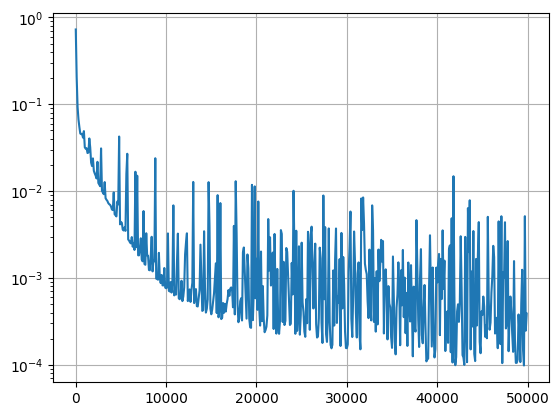

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.semilogy(hist["iter"][::10], hist["loss"][::10])
plt.grid()
plt.show()

In [12]:
import pickle
with open("dataset_train.pkl", "wb") as file:
	pickle.dump([idx_x, idx_t, X_f], file)